In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import plotly.express as px
import datetime
from datetime import timedelta

Цель: выяснить 1. Какой источник рекламы принес больше всего посетителей и денег. 2. Через какой источник рекламы мы видим большую конверсию в первую покупку. 3. Какой процент незарегистрированных посетителей регистрируются, какой процент покупает. 4. Как разные когорты ведут себя во времени (когортный анализ)

### Датасет:  в столбце utm_source находятся каналы привлечения пользователей ###

In [3]:
df = pd.read_csv('SF_case_data.csv')
df

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads
...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads


### График с событиями по дням (события написаны в правом верхнем углу графика)  ###

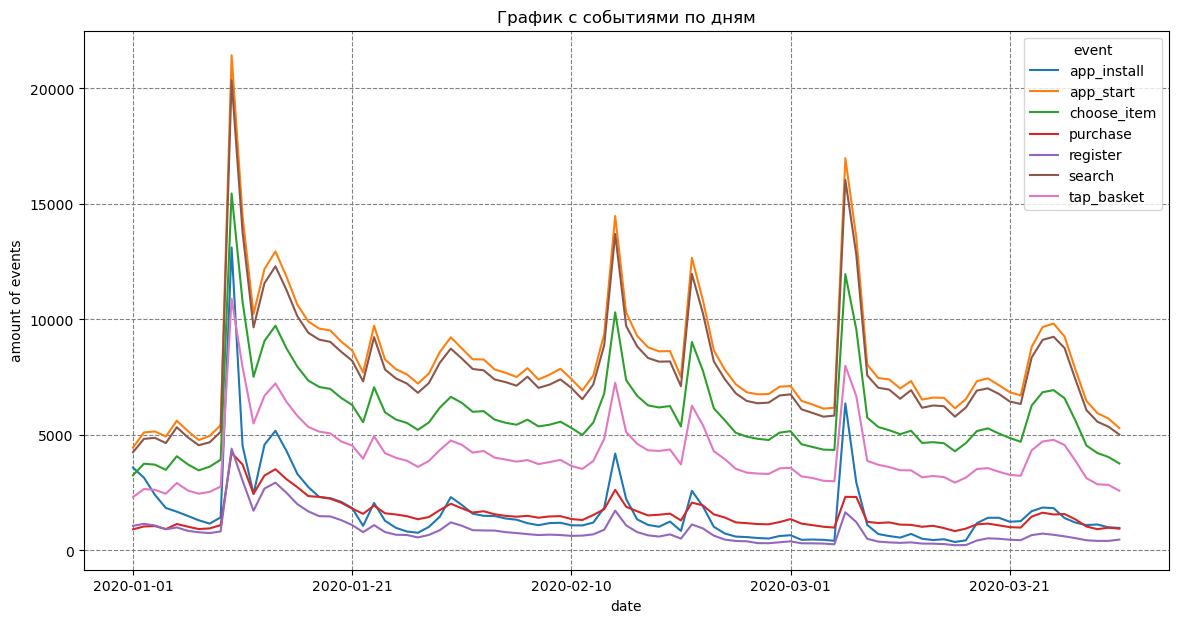

In [4]:
fig, ax = plt.subplots(figsize=(14,7))

df.groupby(['date','event'])['event'].count().unstack().plot(kind='line', ax = ax)
plt.title('График с событиями по дням')
plt.ylabel('amount of events')
plt.xlabel('date')

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.show()

Из графика можно заключить, что в первой половине января, в середине февраля и в начале марта 2020 года трафик был наибольший

### С какого канала рекламы пришло больше всего инсталлов? ###

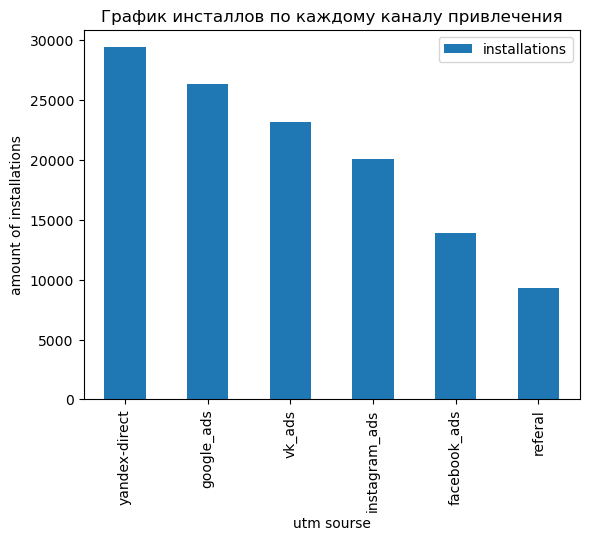

In [5]:
df[df['event']=='app_install'].groupby('utm_source').agg(
    installations=pd.NamedAgg(column='device_id', aggfunc='count')).sort_values(
    by=['installations'], ascending=False).drop('-').plot(kind='bar')

plt.title('График инсталлов по каждому каналу привлечения')
plt.ylabel('amount of installations')
plt.xlabel('utm sourse')

plt.show()

График показывает, что Яндекс приносит больше всего загрузок приложения 

### Анализ: на каком этапе воронки отваливается б’ольшая часть клиентов  ###

#### Добавим столбец с датой регистрации ####

In [6]:
registration = df[df['event'] == 'register']
df['registration'] = df['device_id'].map(registration.set_index('device_id')['date'])
df['isRegistred'] = np.where((df['registration'] < df['date']) | (df['registration'].isna()) | (df['event'] == 'purchase'), True, False)
df

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,registration,isRegistred
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-07,False
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,False
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01-01,False
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01,False
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,NaN,True
...,...,...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads,2020-03-31,False
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-,2020-03-31,False
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads,2020-03-31,False
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads,2020-03-31,False


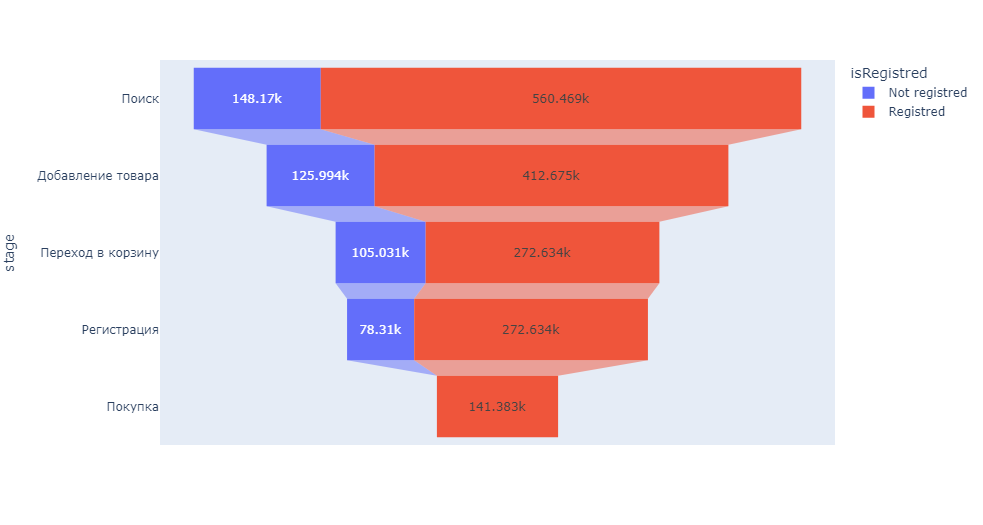

In [13]:
stages = ["Поиск", "Добавление товара", "Переход в корзину", "Регистрация", "Покупка"]
df_not_reg = pd.DataFrame(dict(number=[
    df[(df['event'] == 'search') & (df['isRegistred'] == 0)].device_id.count(),
    df[(df['event'] == 'choose_item') & (df['isRegistred'] == 0)].device_id.count(), 
    df[(df['event'] == 'tap_basket') & (df['isRegistred'] == 0)].device_id.count(), 
    df[df['event'] == 'register'].device_id.count(), 
    0], 
                           stage=stages))
df_not_reg['isRegistred'] = 'Not registred'
df_reg = pd.DataFrame(dict(number=[
    df[(df['event'] == 'search') & (df['isRegistred'] == 1)].device_id.count(), 
    df[(df['event'] == 'choose_item') & (df['isRegistred'] == 1)].device_id.count(), 
    df[(df['event'] == 'tap_basket') & (df['isRegistred'] == 1)].device_id.count(), 
    df[(df['event'] == 'tap_basket') & (df['isRegistred'] == 1)].device_id.count(),
    df[df['event'] == 'purchase'].device_id.count()],
                               stage=stages))
df_reg['isRegistred'] = 'Registred'
data = pd.concat([df_not_reg, df_reg], axis=0)
fig = px.funnel(data, x='number', y='stage', color='isRegistred')
fig.show()

#гитхаб не хочет отображать воронку из notebook, 
#поэтому я ее скачала и перезалила картинкой:
from IPython import display
display.Image("plot.png")

Больше всего незарегистрированных пользователей отваливается на шаге регистрации (доходит только половина). Скорее всего, стоит подумать над тем, как можно упростить этот шаг. Залогиненные пользователи отваливаются на последнем шаге, покупку совершают 40%

### Нахождение лучшего и худшего каналов привлечения по конверсии в первую покупку ###

<AxesSubplot:xlabel='utm_source'>

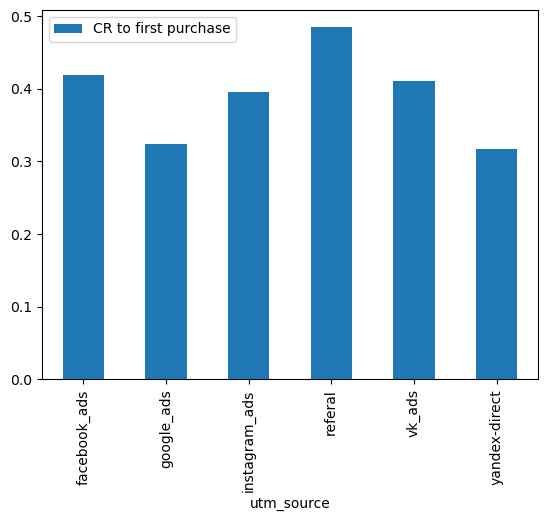

In [8]:
first_opens = df[df['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users who app start')
first_purchase = df[df['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users who purchase')

stat = first_opens.merge(first_purchase, how = 'left', on = 'utm_source')
stat['CR to first purchase'] = stat['users who purchase']/stat['users who app start']
stat.drop([0]).plot.bar(y='CR to first purchase', x = 'utm_source')

По конверсии в первую покупку выиграла реферальная программа, как канал привлечения клиентов. Яндекс занял последнюю строчку  

### Какой платный канал привлечения имеет самый высокий и самый низкий ROMI? ###

ROMI (Return on Marketing Investment) — коэффициент возврата маркетинговых инвестиций. 

In [9]:
#Сумма доходов от маркетинга 
df[df['event'] == 'purchase'].groupby(['utm_source'])['purchase_sum'].sum()

utm_source
-                21449749.5
facebook_ads     12249901.0
google_ads       12868276.0
instagram_ads    14546969.0
referal           8837044.5
vk_ads           16389652.5
yandex-direct    13915368.0
Name: purchase_sum, dtype: float64

In [10]:
#Формула разчета ROMI: (доход от маркетинга - расход на маркетинг)/расход на маркетинг * 100%
print('Яндекс: {} %'.format((13909563-10491707)/10491707*100))
print('Гугл: {} %'.format((12866891-10534878)/10534878*100))
print('Фейсбук: {} %'.format((12248920-8534878)/8534878*100))
print('Инстаграм: {} %'.format((14545448-8561626)/8561626*100))
print('ВК: {} %'.format((16390632-9553531)/9553531*100))

Яндекс: 32.57673894248095 %
Гугл: 22.13611776045247 %
Фейсбук: 43.51605260204071 %
Инстаграм: 69.89118655731984 %
ВК: 71.56621986153601 %


Самый высокий ROMI — у ВК (71 %). Самый низкий ROMI - Гугл (22 %)

## Пользовательская аналитика ##

#### Когортный анализ для отслеживания количества покупок покупателей по месяцам. Столбцы - сколько покупок было очуществено каждой когортов 1, 2 и 3 месяце
#### 

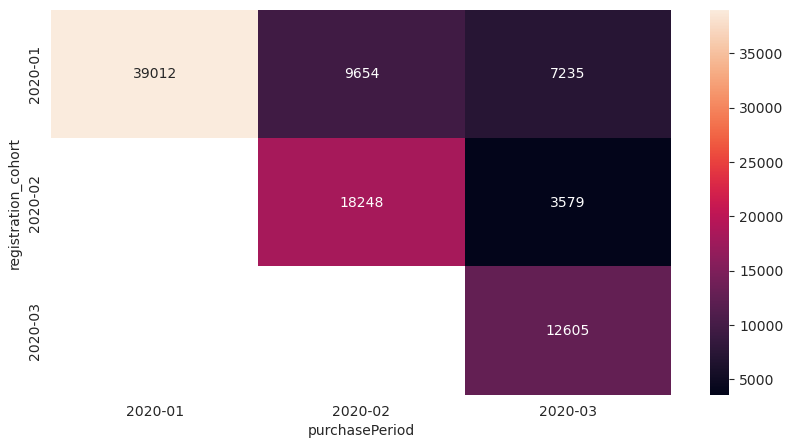

In [11]:
registered = df[df['event'] == 'register'].drop_duplicates('device_id')

df['registration_cohort'] = df['device_id'].map(registered.set_index('device_id')['date'])
df['registration_cohort'] = pd.to_datetime(df['registration_cohort']).dt.to_period('M')
df['purchasePeriod'] = pd.to_datetime(df[(df['event'] == 'purchase')].date).dt.to_period('M')

cohorts = df.pivot_table(index = 'registration_cohort',
                                               columns = 'purchasePeriod',
                                               values = 'device_id', 
                                               aggfunc = 'nunique')
# cohorts.rename(columns={'device_id': 'TotalClients'}, inplace=True)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(cohorts, annot=True, fmt=".0f");

Из когортного анализа можно сделать вывод, что покупательская активность пользователей сильно подает после первого месяца пребывания в приложении. Продолжают покупать во втором месяце только 20-24% из тех, кто покупали в 1 месяце 